In [1]:
import dlc_practical_prologue as prologue
import torch
from torch import nn
from torch.nn import functional as F

def train_model(model, train_input, train_target, train_classes, epochs=25, mini_batch_size=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for e in range(epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            optimizer.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size))
            
            # If model not binary compute main loss against class
            if not model.binary:    
                loss = criterion(output[0], train_classes.narrow(0, b, mini_batch_size)[:,0])
                loss += criterion(output[1], train_classes.narrow(0, b, mini_batch_size)[:,1])
                
            # else compute against main target
            else:
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            
            # Compute auxiliary loss against class information
            if model.aux:
                left, right = model.get_subnetwork_output()
                classes = train_classes.narrow(0, b, mini_batch_size)
                loss += criterion(left, classes[:, 0])
                loss += criterion(right, classes[:, 1])

            loss.backward()
            optimizer.step()

In [2]:
class DigitSubnetwork(nn.Module):

    def __init__(self, aux=False, nb_hidden=200):
        super(DigitSubnetwork, self).__init__()
        self.aux = aux
        self.aux_out = None
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(4 * 4 * 16, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)
        
        if self.aux:
            self.fcaux = nn.Linear(6 * 6 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, kernel_size=2))
        
        if self.aux:
            self.aux_out = self.fcaux(x.view(-1, 6 * 6 * 8))
        
        x = self.conv2(x)
            
        x = F.relu(x)

        x = F.relu(self.fc1(x.view(-1, 4 * 4 * 16)))
        x = self.fc2(x)

        return x, self.aux_out

class Model(nn.Module):
    def __init__(self, weight_sharing=False, aux=False, binary=False):
        super(Model, self).__init__()
        # compute auxiliary loss from DigitSubnetwork hidden layer if model output not binary
        self.left = DigitSubnetwork(aux and not binary)
        self.weight_sharing = weight_sharing
        self.aux = aux
        self.binary = binary
        
        if not weight_sharing:
            self.right = DigitSubnetwork(aux and not binary)
            
        if binary:
            self.fc = nn.Linear(20, 200)
            self.fc2 = nn.Linear(200, 2)

        self.left_out = None
        self.right_out = None

    def get_subnetwork_output(self):
        return (self.left_out, self.right_out)

    def forward(self, x):
        left, left_aux_out = self.left(x[:, 0, :, :].unsqueeze(1))
        if not self.weight_sharing:
            right, right_aux_out = self.right(x[:, 1, :, :].unsqueeze(1))
        else:
            right, right_aux_out = self.left(x[:, 1, :, :].unsqueeze(1))

        self.left_out = left
        self.right_out = right
        
        if self.aux and not self.binary:
            self.left_out = left_aux_out
            self.right_out = right_aux_out
        
        if not self.binary:
            return left, right
        else:
            x = torch.cat((left, right), dim=1)
            x = self.fc(x)
            x = F.relu(x)
            x = self.fc2(x)
            return x

In [3]:
def compute_accuracy(inp, targ, model):
    if model.binary:
        out = model(inp)
        pred = torch.argmax(out, dim=1)
        errors = torch.abs(pred - targ).sum().item()
        
    else:
        out_1, out_2 = model(inp)
        pred_1, pred_2 = torch.argmax(out_1, dim=1), torch.argmax(out_2, dim=1) 

        difference = pred_2 - pred_1
        difference[difference >= 0] = 1
        difference[difference < 0] = 0

        errors = torch.sum(torch.abs(difference - targ)).item()
    
    return 100 * (1 - errors/inp.shape[0])

In [4]:
def get_results(n_pairs=1000, rounds=10):
    results = []
    model_params = [[False, False, True], 
                    [True, False, True], 
                    [False, True, True], 
                    [True, True, True],
                    
                    [False, False, False], 
                    [True, False, False], 
                    [False, True, False], 
                    [True, True, False]]
    
    for p in model_params:
        model = Model(weight_sharing=p[0], aux=p[1], binary=p[2])
        accuracies = []
        model_id = model_params.index(p)+1
        
        print("Model {}:".format(model_id))
        
        for i in range(rounds):
        
            # generate train/test data
            train_input, train_target, train_classes, test_input, test_target, test_classes = \
                prologue.generate_pair_sets(n_pairs)

            # normalize inputs
            train_input = train_input.sub_(torch.mean(train_input)).div_(torch.std(train_input))
            test_input = test_input.sub_(torch.mean(test_input)).div_(torch.std(test_input))
            
            # train model
            train_model(model, train_input, train_target, train_classes)
            
            # compute test accuracy
            accuracy = compute_accuracy(test_input, test_target, model)  
            accuracies.append(accuracy)
        
        accuracy_avg = round(sum(accuracies)/rounds,2)
        accuracy_stdev = round((sum([(x-accuracy_avg)**2 for x in accuracies])/(rounds-1))**0.5,2)
        results.append([model_id, accuracy_avg, accuracy_stdev])    
        
        print("Avg test acc %: {}".format(accuracy_avg))
        print("Stdev test acc %: {}".format(accuracy_stdev))
        print('-'*30)
        
    return results

In [5]:
test_results = get_results()

Model 1:
Avg test acc %: 86.03
Stdev test acc %: 3.45
------------------------------
Model 2:
Avg test acc %: 88.57
Stdev test acc %: 1.96
------------------------------
Model 3:
Avg test acc %: 92.53
Stdev test acc %: 2.85
------------------------------
Model 4:
Avg test acc %: 93.43
Stdev test acc %: 2.62
------------------------------
Model 5:
Avg test acc %: 96.69
Stdev test acc %: 1.22
------------------------------
Model 6:
Avg test acc %: 97.38
Stdev test acc %: 1.3
------------------------------
Model 7:
Avg test acc %: 96.48
Stdev test acc %: 1.22
------------------------------
Model 8:
Avg test acc %: 97.32
Stdev test acc %: 1.16
------------------------------


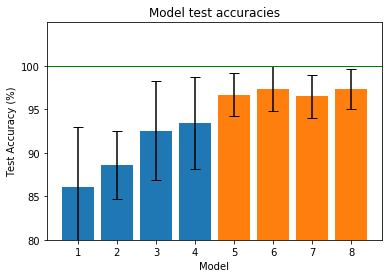

In [6]:
import matplotlib.pyplot as plt
plt.bar(range(1,5), [x[1] for x in test_results[:4]], yerr=[x[2]*2 for x in test_results[:4]], capsize=5)
plt.bar(range(5,9), [x[1] for x in test_results[4:]], yerr=[x[2]*2 for x in test_results[4:]], capsize=5)
plt.axhline(y=100,linewidth=1, color='g')
plt.ylim(80)
plt.xlabel('Model')
plt.ylabel('Test Accuracy (%)')
plt.title('Model test accuracies')
plt.show()